In [81]:
## imports

import os
import matplotlib
from pathlib import Path
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import napari
import gunpowder as gp
import warnings
warnings.filterwarnings('ignore')

### Load data

In [82]:
base_path = Path("/mnt/shared/celltracking/data/cho/")
#base_path = Path("/mnt/shared/celltracking/data/celegans/")
img = np.stack([imread(xi) for xi in sorted((base_path / "01").glob("*.tif"))])  # images
seg = np.stack([imread(xi) for xi in sorted((base_path / "01_ST/SEG").glob("*.tif"))])  # images
tra = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

### Have a look at data structure

### View imported data with napari

In [83]:
viewer = napari.Viewer()
viewer.add_image(img, name="image");
viewer.add_image(tra,name='tra');
viewer.add_image(seg,name='seg');

### View flatened images

In [84]:
img_flat = img.sum(axis=1)
tra_flat = tra.sum(axis=1)
img_flat.shape
viewer.add_image(img_flat, name="image_flat");
viewer.add_image(tra_flat,name='tra_flat');

  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/llanosp/miniconda3/envs/exercise08_v2/lib/python3.9/asyncio/base_events.py

In [85]:
# provide path to zarr directory
#zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

In [ ]:
#f = zarr.open(zarrdir, 'w')
#f['raw'] = raw_data
#f['raw'].attrs['resolution'] = (1, 1, 1)
#f['ground_truth'] = gt_data
#f['ground_truth'].attrs['resolution'] = (1, 1, 1)


### Look at subvolumes extracted with gunpowder

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



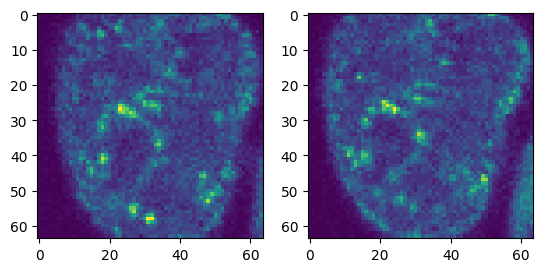

In [102]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

# pre-selected volumes from cho dataset
coord_paired = ((0,0,80, 175),(1,0,80, 180))
coord_unpaired = ((0,0,80, 175),(1,0,92, 232))

# specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)
pipeline = gp.Pipeline(source)

# specify request paired
request_vol1p = gp.BatchRequest()
request_vol2p = gp.BatchRequest()
request_vol1p[raw] = gp.Roi(coord_paired[0], volSize)
request_vol2p[raw] = gp.Roi(coord_paired[1], volSize)

# specify request unpaired
request_vol1u = gp.BatchRequest()
request_vol2u = gp.BatchRequest()
request_vol1u[raw] = gp.Roi(coord_unpaired[0], volSize)
request_vol2u[raw] = gp.Roi(coord_unpaired[1], volSize)

# build the pipeline
with gp.build(pipeline):
    batch_vol1p = pipeline.request_batch(request_vol1p)
    batch_vol2p = pipeline.request_batch(request_vol2p)
    batch_vol1u = pipeline.request_batch(request_vol1u)
    batch_vol2u = pipeline.request_batch(request_vol2u)
    
# show the content of the batch
print(f"batch returned: {batch}")

# plot first slice of volume

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.flipud(batch_vol1p[raw].data[0,1,:,:]))
ax2.imshow(np.flipud(batch_vol2p[raw].data[0,1,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



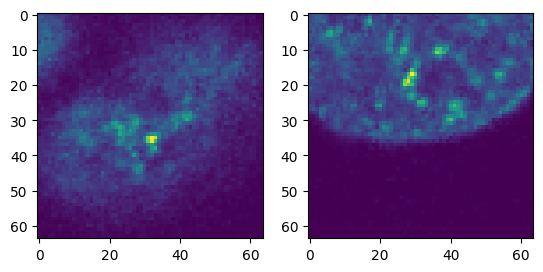

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



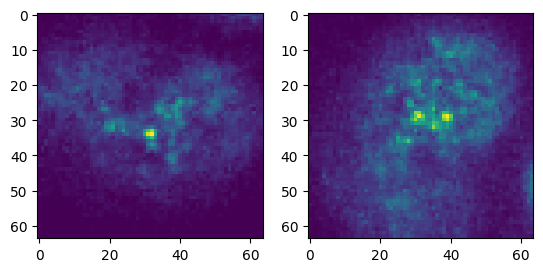

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



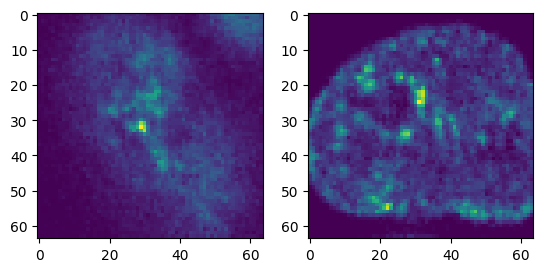

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



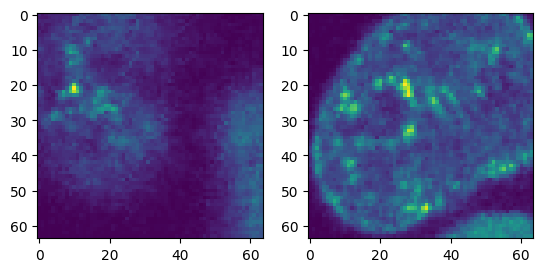

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



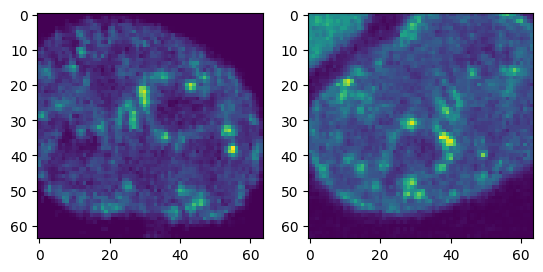

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



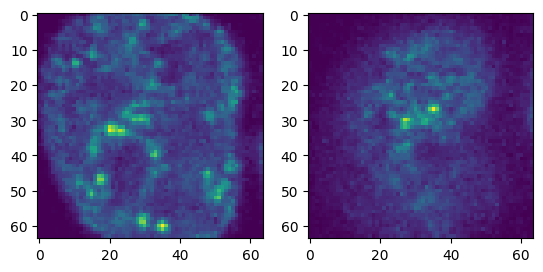

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



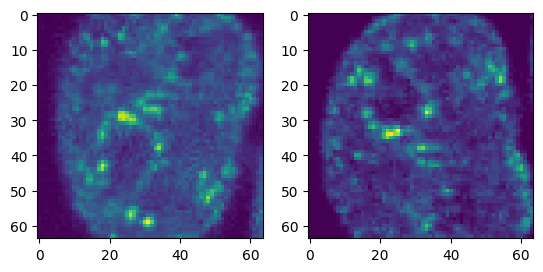

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



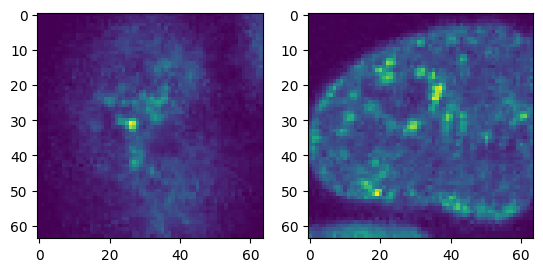

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



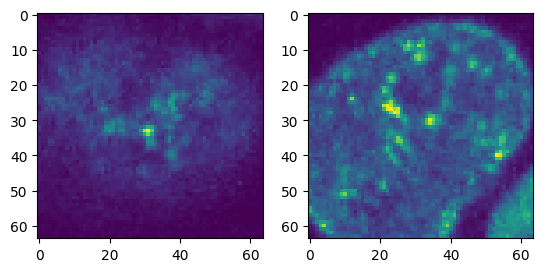

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



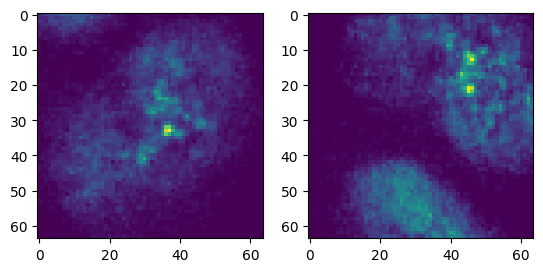

In [103]:
#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

# elastically deform the batch
Elastic_augment=gp.ElasticAugment(
    [4,40,40],
    [0,2,2],
    [0,math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

# apply transpose and mirror augmentations
Simple_augment=gp.SimpleAugment(transpose_only=[2, 3]) 

# scale and shift the intensity of the raw array
Intensity_augment=gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) 

pipeline = (
    source + gp.Normalize(raw)+
            Intensity_augment+Elastic_augment + Simple_augment
           )


# build the pipeline
with gp.build(pipeline):
    for x in range(10):
        batch_vol1p = pipeline.request_batch(request_vol1p)
        batch_vol2p = pipeline.request_batch(request_vol2p)
        batch_vol1u = pipeline.request_batch(request_vol1u)
        batch_vol2u = pipeline.request_batch(request_vol2u)
        # show the content of the batch
        print(f"batch returned: {batch}")

        # plot first slice of volume

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(np.flipud(batch_vol1p[raw].data[0,1,:,:]))
        ax2.imshow(np.flipud(batch_vol2p[raw].data[0,1,:,:]))
        plt.show()

with gp.build(pipeline):
    for x in range(10):
        batch_vol1p = pipeline.request_batch(request_vol1p)
        batch_vol2p = pipeline.request_batch(request_vol2p)
        batch_vol1u = pipeline.request_batch(request_vol1u)
        batch_vol2u = pipeline.request_batch(request_vol2u)


In [ ]:
# Model Implementation for 3D Cell Tracking


!pip install torchsummary 

from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Designed VGG Model from Exercise 9

We will use a VGG network to classify the synapse images. The input to the network will be a 2D image as provided by your dataloader. The output will be a vector of six floats, corresponding to the probability of the input to belong to the six classes.

Implement a VGG network with the following specificatons:

* the constructor takes the size of the 2D input image as height and width
* the network starts with a downsample path consisting of:
    * one convolutional layer, kernel size (3, 3), to create 12 `fmaps`
    * `nn.BatchNorm2d` over those feature maps
    * `nn.ReLU` activation function
    * `nn.Conv2d` layer, kernel size (3, 3), to create 12 `fmaps`
    * `nn.BatchNorm2d` over those feature maps
    * `nn.ReLU` activation function
    * `nn.MaxPool2d` with a `downsample_factor` of (2, 2) at each level
* followed by three more downsampling paths like the one above, every time doubling the number of `fmaps` (i.e., the second one will have 24, the third 48, and the fourth 96). Make sure to keep track of the `current_fmaps` each time!
* then two times:
    * `nn.Linear` layer with `out_features=4096`. Be careful withe in `in_features` of the first one, which will depend on the size of the previous output!
    * `nn.ReLU` activation function
    * `nn.DropOut`
* Finally, one more fully connected layer with
    * `nn.Linear` to the 6 classes
    * no activation function 

Original One (from https://blog.paperspace.com/vgg-from-scratch-pytorch/)
https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/vgg.py#L24

# Create and Load Artificial Data
Make a fake dataset to test on the VGG model while waiting for data.


#original data size = 512x712x34 

fd_class1 = np.random.randn(1, 1, 128,128,128) + 0.5
fd_class2 = np.random.randn(1,1,128,128,128)
y1 = 1
y2 = 0
# fd_class1 = np.expand_dims(fd_class1, axis=0)
# fd_class2 = np.expand_dims(fd_class2, axis=0)

loader = [(fd_class1, y1), (fd_class2,y2)]

#Split
# train_set_size = int(len(fd_class1) * 0.7)
# valid_set_size = int(len(fd_class1) * 0.2)
# test_data_size = len(fd_class1) - train_set_size - valid_set_size
    
# train_data_C1, val_data_C1, test_data_C1 = random_split(
#     fd_class1,
#     [train_set_size, valid_set_size, test_data_size],
#     generator=torch.Generator().manual_seed(23061912))

# train_data_C2, val_data_C2, test_data_C2 = random_split(
#     fd_class2,
#     [train_set_size, valid_set_size, test_data_size],
#     generator=torch.Generator().manual_seed(23061912))

#train = np.ndarray.flatten(fd_class1)
#train2 = np.ndarray.flatten(fd_class2)




#sampler = balanced_sampler(train_data_C1)
#dataloader = DataLoader(train_data_C1, batch_size=8, drop_last=True)

# Define the Model

class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

# Training and Evaluation

# Loss Functions

We'll probably need to test some different loss functions. List some here:
Contrastive loss
cosine similarity
triplet loss



class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

input_size = (1, 128, 128, 128)
downsample_factors =[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)];
output_classes = 12

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)

summary(model, input_size)

#Training length
epochs = 2000

#loss_function = torch.nn.BCELoss()
#loss_function = torch.nn.CosineSimilarity()
loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# Training Test

from tqdm import tqdm

def train():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    loss=[] 
    counter=[]
    with gp.build(pipeline):
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0
            
            for x in range(100):
                unpaired1 = pipeline.request_batch(request_vol1)
                unpaired2 = pipeline.request_batch(request_vol2)
                y = 0
            for i, (x, y) in enumerate(loader):

                x = torch.from_numpy(x).to(device).float()
                y = torch.from_numpy(np.array([y])).to(device).float()

                #vol0, vol1 , label = data
                #vol0, vol1 , label = vol0.to(device), vol1.to(device) , label.to(device)

                optimizer.zero_grad()

                pred = model(x).mean(axis = 1).sigmoid()
                #print(model(x))
                #output1 = model(vol0)
                #output2 = model(vol1)

                #print(pred,y)
                loss = loss_function(pred, y)
                #loss_contrastive = loss_function(output1,output2,label)

                loss.backward()
                optimizer.step()    
                epoch_loss += loss

            print(f"epoch {epoch}, training loss={epoch_loss}")
    
    #show_plot(epoch, loss)
    
    return model

model = train()

# Implementing the Siamese Network

The above training is just to test if the VGG model works for 3D data. Here, the training will take two pairs of images and calculate the loss from both pairs of images.

from tqdm import tqdm

def train():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    loss=[] 
    counter=[]
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for i, (x, y) in enumerate(loader):
            
            x = torch.from_numpy(x).to(device).float()
            y = torch.from_numpy(np.array([y])).to(device).float()
            
            #vol0, vol1 , label = data
            #vol0, vol1 , label = vol0.to(device), vol1.to(device) , label.to(device)
            
            optimizer.zero_grad()
            
            pred = model(x).mean(axis = 1).sigmoid()
            #print(model(x))
            #output1 = model(vol0)
            #output2 = model(vol1)
            
            #print(pred,y)
            loss = loss_function(pred, y)
            #loss_contrastive = loss_function(output1,output2,label)
            
            loss.backward()
            optimizer.step()    
            epoch_loss += loss
            
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
    return model

model = train()

for i, (x, y) in enumerate(loader):
    #print(i)
    print(np.shape(x))
    print((y))
#print(x)
#print(y)

